In [151]:
import os
import re

os.chdir("/home/s2113174/Projects-1")

from Gala import llaplace

import torch
from torch.autograd import Variable, grad
from torch import linalg as LA

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from pyDOE import lhs
import scipy.io

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Heat Equation

$$\frac{\partial u}{\partial t} = k \frac{\partial^{2} u}{\partial x^{2}} + sin(5 \pi x)$$
$$u(x,0) = 4sin(3 \pi x)+ 9sin(7 \pi x),  u(0,t)=u(1,t)=0$$

In [152]:
def exact_solution(x,t,theta):
    u = 4*np.sin(3*np.pi*x)*np.exp(-theta*((3*np.pi)**2)*t) + 9*np.sin(7*np.pi*x)*np.exp(-theta*((7*np.pi)**2)*t) + \
    (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)*np.exp(-theta*((5*np.pi)**2)*t) - (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)
    return u    

## Feed Forward Neural Network

In [153]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Heat Equation definition for the NN

In [154]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)- torch.sin(5*torch.pi*data_domain[:,0].reshape(-1,1))

    return f

def ini_c(self,data_inic):
    u = self(data_inic)
    return u - 4*torch.sin(3*torch.pi*data_inic[:,0].reshape(-1,1)) - 9*torch.sin(7*torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [155]:
DNN.de = de
DNN.ini_c = ini_c
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [156]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [157]:
def data_pde(size,maxl,minp,maxp):

    xy, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(x).float(),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [158]:
# Number of observations
epochs = 1200
nobs = 1500
lr = 0.01

min_param, max_param, space = 0.0001, 0.05,1

x, y = np.linspace(0,1,100), np.linspace(0,1.5,100)

xx,yy = np.meshgrid(x, y)

pde_domain,ini_c,left_bc,right_bc = data_pde(nobs,space,min_param,max_param)

pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain,requires_grad=True),
                   "ini_c" : ini_c,
                   "left_bc":left_bc,
                   "right_bc" :right_bc}}

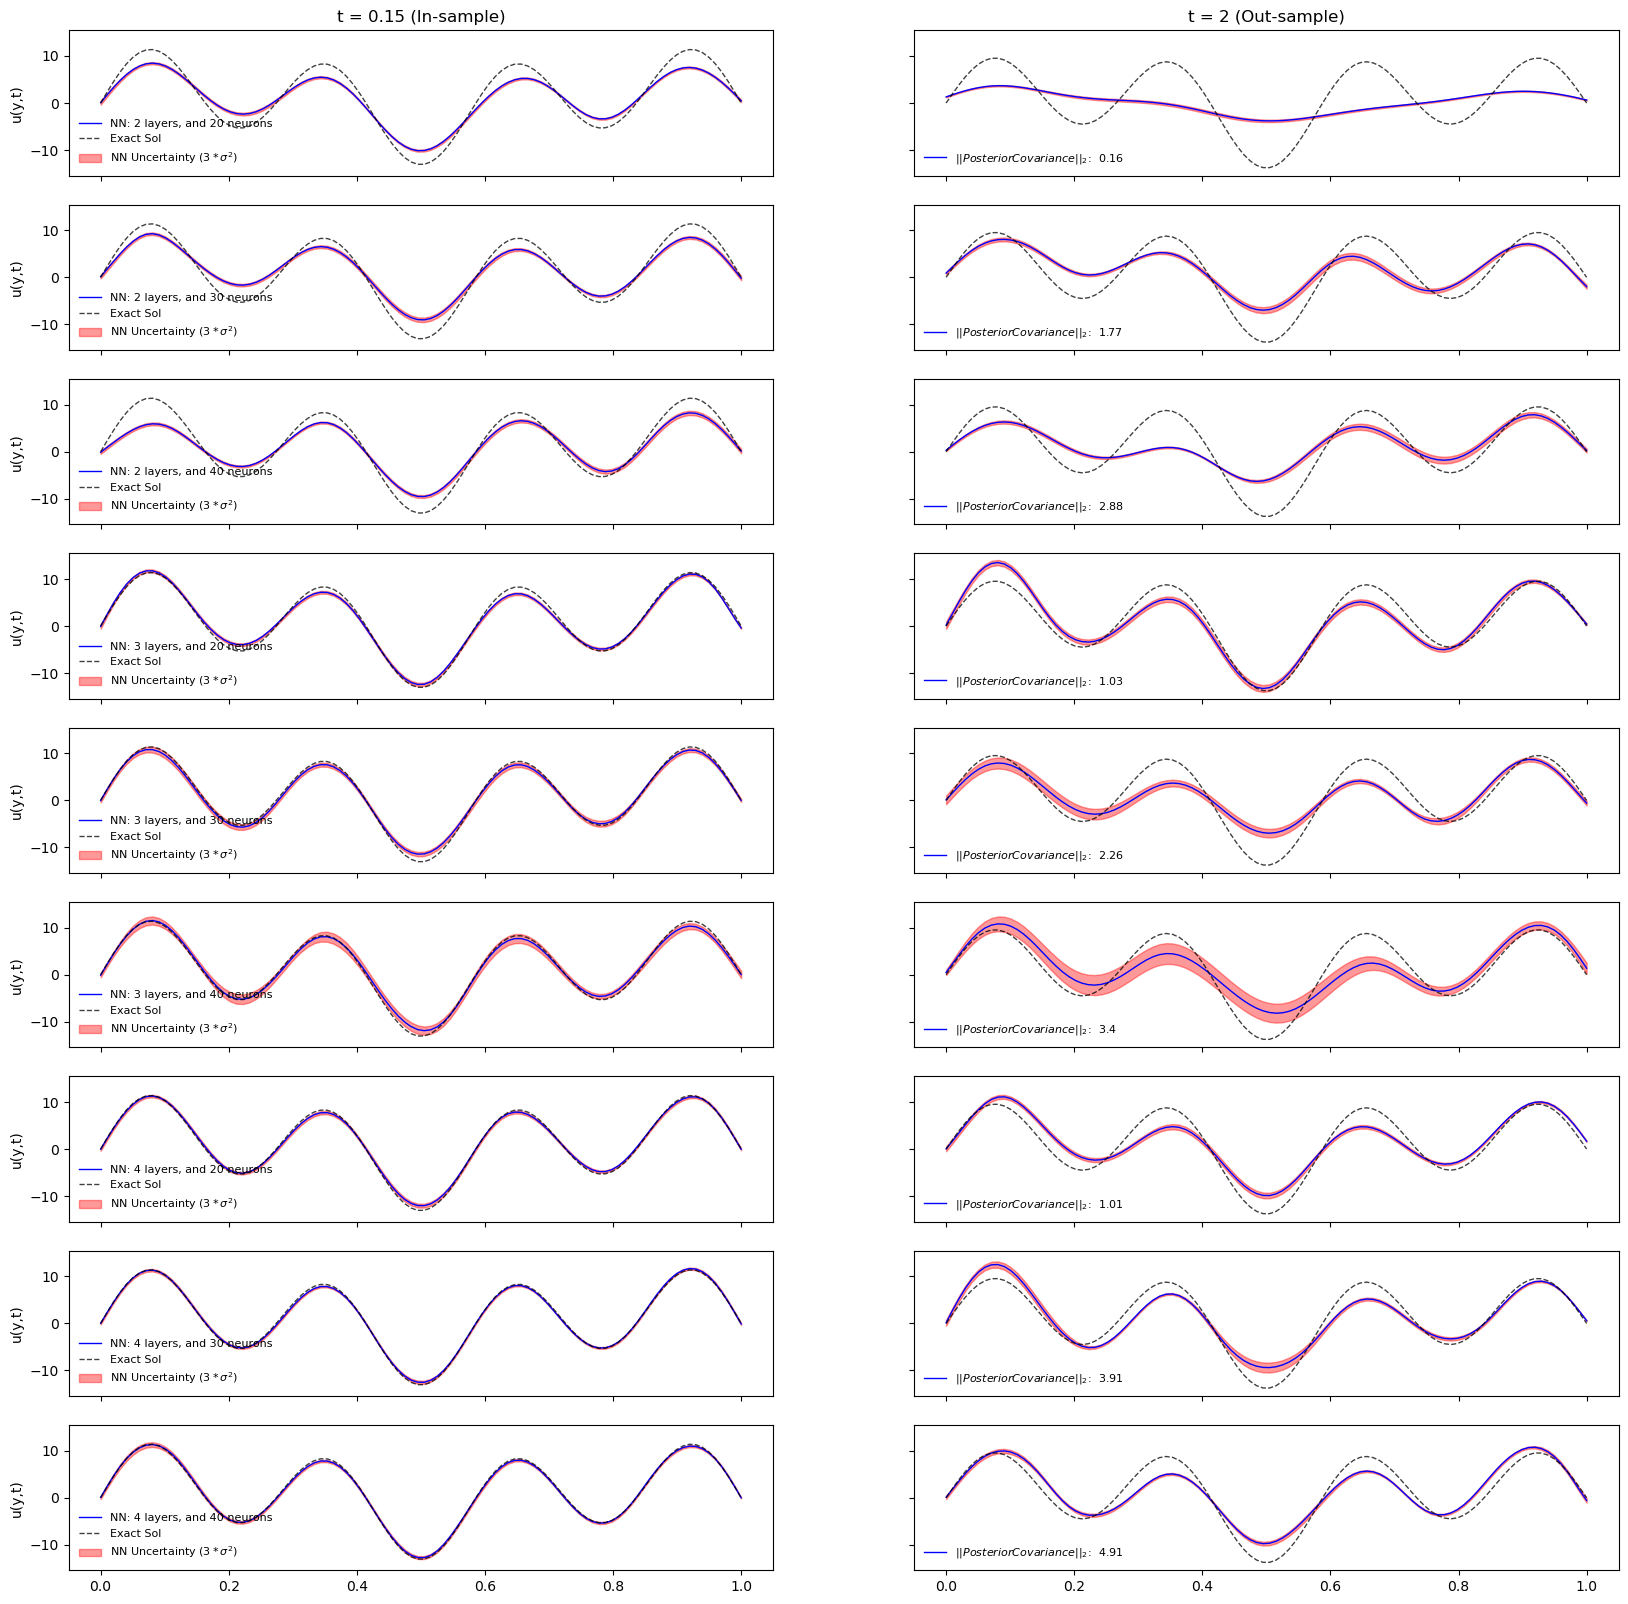

In [159]:
pr =  np.array([0.0001])
fig, axs = plt.subplots(9, 2, figsize=(20,20), sharey=True,sharex=True)
plt.rcParams.update({'font.size': 10})
counter = 0 

for layer in [2,3,4]:
    for neuron in [20,30,40]:

        layers = [3] + layer*[neuron] + [1]

        model = DNN(layers)

        model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/HeatEq_{layer}_{neuron}.pt"))
        model.eval()

        llp = llaplace(model)
        llp.fit(pde=pde, hessian_structure = "full")
        
        pcovariance = LA.norm(llp.posterior_covariance)

        X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

        f_mu, f_sigma = llp(X_star)

        f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()
        

        z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
        z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

        z_exact = exact_solution(xx,yy,pr)

        axs[0,0].set_title(fr"t = 0.15 (In-sample)",color = "black")
        axs[counter,0].plot(x,z_pred[10,:],color = "blue", label = f"NN: {layer} layers, and {neuron} neurons",linewidth=1)
        axs[counter,0].plot(x,z_exact[10,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=1)
        axs[counter,0].fill_between(x, z_pred[10,:]+3*z_pred_var[10,:],z_pred[10,:]-3*z_pred_var[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($3*\sigma^{2})$")
        axs[counter,0].legend(frameon = False, prop={'size': 8},loc='lower left')
        axs[counter,0].set_ylabel(r'u(y,t)')

        axs[0,1].set_title(fr"t = 2 (Out-sample)",color = "black")
        axs[counter,1].plot(x,z_pred[-1,:],color = "blue",linewidth=1,label = fr"$||Posterior Covariance||_{2}$: {pcovariance: 0.3}")
        axs[counter,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=1)
        axs[counter,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")
        axs[counter,1].legend(frameon = False, prop={'size': 8})
        axs[counter,1].legend(frameon = False, prop={'size': 8},loc='lower left')

        counter +=1

## Burgers EQ

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

In [160]:
def de2(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u.reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return f

def ini_c2(self,data_inic):
    u = self(data_inic)
    return u + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc2(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc2(self,data_rbc):
    u = self(data_rbc)
    return u

In [161]:
DNN.de2 = de2
DNN.ini_c2 = ini_c2
DNN.left_bc2 = left_bc2
DNN.right_bc2 = right_bc2

In [162]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl*(2)-1
    #t_f_train[:,0] = t_f_train[:,0]*(2)-1
    #t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [163]:
def data_pde_b(size,maxl,minp,maxp):

    xy, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [164]:
epochs = 1200
nobs = 2000
lr = 0.01

min_param , max_param,space = 0.0001, 0.05, 1

xx,yy = np.meshgrid(x, y)

data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')
y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
xx, yy = np.meshgrid(x, y)

Exact = np.real(data['usol']).T

pde_domain,ini_c,left_bc,right_bc = data_pde_b(nobs,space,min_param,max_param)

pde = {"PDE":["de2","ini_c2","left_bc2","right_bc2"], 
       "data_set":{"de2" : Variable(pde_domain,requires_grad=True),
                   "ini_c2" : ini_c,
                   "left_bc2":left_bc,
                   "right_bc2" :right_bc}}

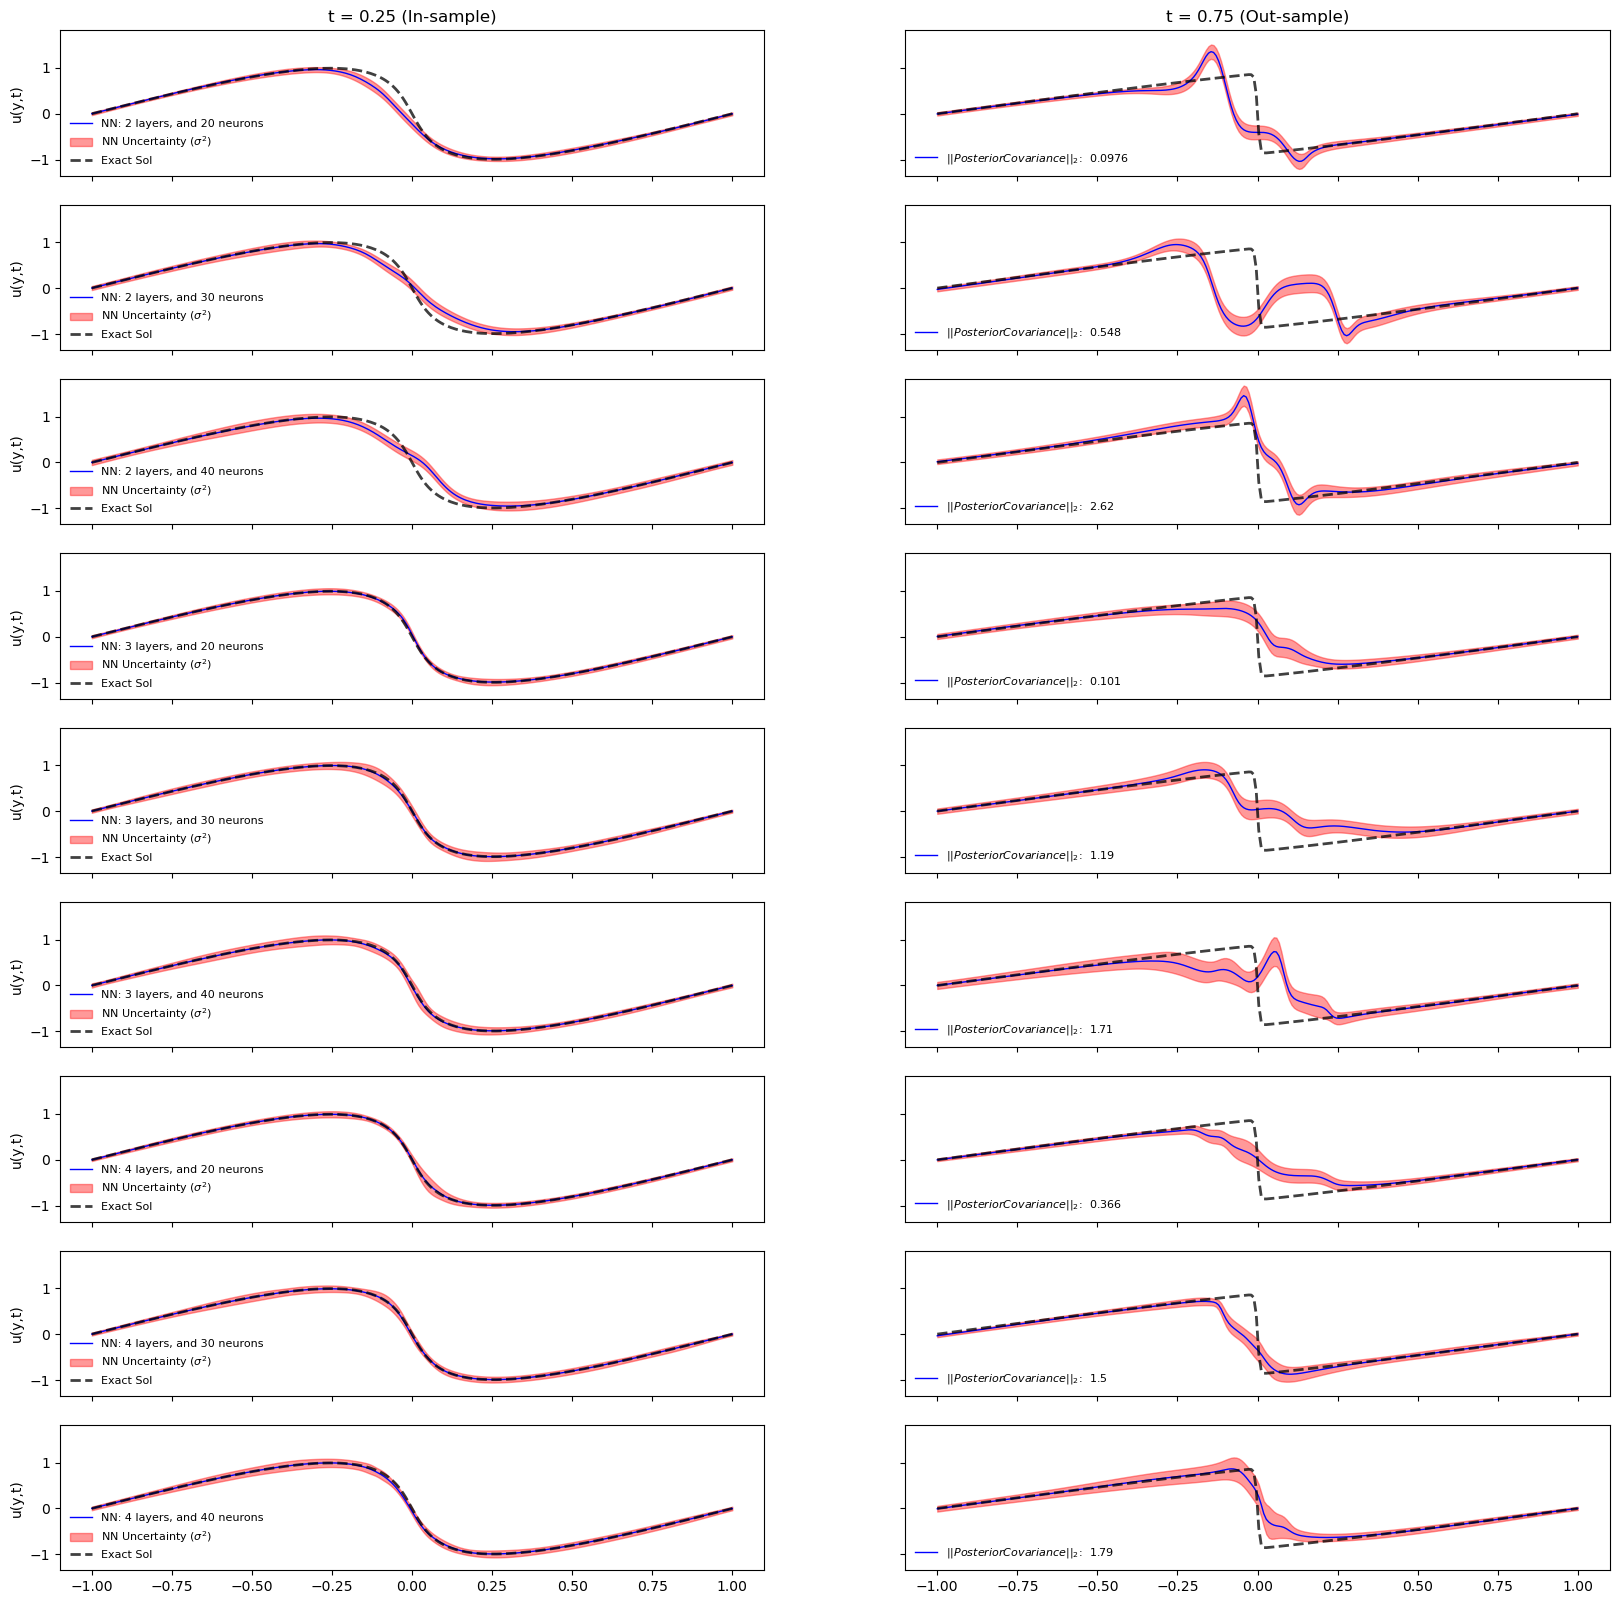

In [165]:
pr =  np.array([(0.01/np.pi)])
fig, axs = plt.subplots(9, 2, figsize=(20,20), sharey=True,sharex=True)
plt.rcParams.update({'font.size': 10})
counter = 0 

for layer in [2,3,4]:
    for neuron in [20,30,40]:

        layers = [3] + layer*[neuron] + [1]

        model = DNN(layers)

        model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/BurgEq_{layer}_{neuron}.pt"))
        model.eval()

        llp = llaplace(model)
        llp.fit(pde=pde, hessian_structure = "full")

        pcovariance = LA.norm(llp.posterior_covariance)

        X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

        f_mu, f_sigma = llp(X_star)

        f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()
        

        z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
        z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

        z_exact = Exact

        axs[0,0].set_title(fr"t = 0.25 (In-sample)",color = "black")
        axs[counter,0].plot(x,z_pred[25,:],color = "blue", label = f"NN: {layer} layers, and {neuron} neurons",linewidth=1)
        axs[counter,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[counter,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
        axs[counter,0].set_ylabel(r'u(y,t)')
        axs[counter,0].legend(frameon = False, prop={'size': 8},loc='lower left')

        axs[0,1].set_title(fr"t = 0.75 (Out-sample)",color = "black")
        axs[counter,1].plot(x,z_pred[75,:],color = "blue",linewidth=1, label = fr"$||Posterior Covariance||_{2}$: {pcovariance: 0.3}")
        axs[counter,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
        axs[counter,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
        axs[counter,1].legend(frameon = False, prop={'size': 8},loc='lower left')

        counter +=1
